# Analysis of Question 3 results

The following notebook analyses the results using helper code. First, let's define methods that will asist us further.

In [39]:
# Load the predicted and gold results

def load(predicted, gold):
    out = []
    for file_name in [predicted, gold]:
        with open(file_name, 'r') as f:
            out.append(f.read().splitlines())
    return out
    
predicted, gold = load('../output/predicted3.txt', '../data/heb-ctrees.mini')
assert len(predicted) <= len(gold)

In [40]:
# Load evalb output file to a dataframe

from collections import defaultdict
import pandas as pd

def load_eval(file_name):
    out = defaultdict(dict)
    t_tags = ['index', '_', '_', '_', 'parent', 'tag']
    nt_tags = ['index', '_', '_', '_', 'start', 'end', 'tag']
    int_tags = ['index', 'start', 'end']
    meta_tags = ['ID', 'Len.', 'Stat.', 'Recal', 'Prec.', 'Matched Bracket', 'Bracket gold', 'Bracket test', 'Cross Bracket', 'Words', 'Correct Tags', 'Tag Accracy']
    with open(file_name, 'r') as f:
        started = False

        for line in f:
            split = [word for word in line.strip().split(' ') if word]
            if len(split) == 12:
                try:
                    _ = float(split[-2])  # Only meta lines have floats at [-2]
                    line_num = int(split[0])
                    out[line_num]['line'] = gold[line_num - 1]
                    out[line_num]['meta'] = dict(zip(meta_tags, map(float, split)))
                    continue
                except ValueError:
                    pass

            if line == '============================================================================\n':
                if not started:
                    started = True
                else:
                    return out  # ended
            elif not started:
                continue
            else:
                if len(split) == 12 or len(split) == 14:
                    parsing_terminals = len(split) == 12
                    keys = ['t-predicted', 't-gold'] if parsing_terminals else ['nt-predicted', 'nt-gold']
                    tags = t_tags if parsing_terminals else nt_tags

                    half = int(len(split) / 2)
                    for i, place in enumerate(keys):
                        out[line_num][place] = out[line_num].get(place, [])
                        place_tags = dict(zip(tags, split[i * half:(i + 1) * half]))
                        for t in int_tags:
                            if t in place_tags:
                                place_tags[t] = int(place_tags[t])
                        out[line_num][place].append(place_tags)
    return out

evalb = load_eval('../output/evalb-result3.txt')

data = [r['meta'] for r in evalb.values()]
evalb_df = pd.DataFrame(data)

For starters, we notice the obvious. There's a negative correlation between the __length__ of the sentence and the Precision/Recall metrics.

In [41]:
evalb_df.corr()['Len.'].loc[['Prec.', 'Recal']]

Prec.    0.111686
Recal    0.140819
Name: Len., dtype: float64

But, suprsingly, the correlation isn't that low, and there's no negative correlation between the __length__ of the sentence and the tag accuracy.

In [42]:
evalb_df.corr()['Len.'].loc[['Tag Accracy']]

Tag Accracy    0.19497
Name: Len., dtype: float64

Now, we move deeper to analyze our __PCFG__ model internals.

Some helper method below:

In [43]:
# Load the trained model
import sys
sys.path.append('..')
import dill
pickle_file = "../pcfg-p.pe"
with open(pickle_file, "rb") as f:
    pcfg = dill.load(f)

In [44]:
# Display helper methods
import svgling, svgling.html, svgling.figure
from svgling.figure import SideBySide, RowByRow, Caption
from svgling.core import VertAlign
import json
import re
from util.transliteration import to_heb, _trans_symbols
from IPython.core.display import display, HTML

def translate(word):
    if word in _trans_symbols:
        ret = to_heb(word)
        if ret=='"':
            return "\\\""
        return ret
    else:
        return word.lower()+"\\n"+"".join(map(to_heb, word)).replace('"', "\\\"")

def translate_replace(word):
    return word.group(1) + translate(word.group(2)) +  word.group(3)

def to_graph(line):
    formatted = line.replace("(","[").replace(")","]")
    formatted = re.sub(r'([a-zA-Z]+)', r'"\1"',formatted)
    formatted = re.sub(r'(\s\")([a-zA-Z]+)(\"\])', translate_replace, formatted)
    formatted = re.sub(r'\s', r',',formatted)
    graph = json.loads(formatted)
    return graph

def html(text, tag):
    display(HTML(f'<{tag}>{text}</{tag}>'))

def h1(text):
    html(text, 'h1')

def h2(text):
    html(text, 'h2')
    
def h3(text):
    html(text, 'h3')
    
def describe(line_num, p_boxes=None, g_boxes=None):
    meta = evalb[line_num]['meta']
    h2(f'Line {line_num}')
    
    pred_graph = svgling.draw_tree(to_graph(predicted[line_num-1]), distance_to_daughter=0.2, leaf_nodes_align=True)
    gold_graph = svgling.draw_tree(to_graph(gold[line_num-1]), distance_to_daughter=0.2, leaf_nodes_align=True)
    
    for b in p_boxes or []:
        pred_graph.box_constituent(b)
    for b in g_boxes or []:
        gold_graph.box_constituent(b)
    
    printer = SideBySide if meta['Len.']<9 else RowByRow
    display(printer(Caption(pred_graph, "Prediction"), Caption(gold_graph, "Gold")))

In [94]:
# PCFG model inspection method

known_words = set(pcfg.reverse_rules['T'].keys())

def to_leafs(line): # return the leafs of a bracket notated line
    return re.findall(r'([\w]+)\)', line)
        
def get_parent_to_child(parent, child, child_side):
    index = 0 if child_side=='left' else 1
    parent_to_child = dict((t,prob) for t, prob in pcfg.rules[parent][pcfg.NON_TERMINAL_RULES].items() 
                           if (len(t)==2 and t[index]==child) or (len(t)==1 and t[0]==child))
    return sorted(parent_to_child.items(), key=lambda t:-t[1])

def get_possible_terminal_tags(terminal):
    return pcfg.reverse_rules['T'].get(terminal.upper(), [])

def get_unknown_score(terminal):
    unknowns = sorted(pcfg.unknown_rules, key=lambda k: -pcfg.unknown_rules[k]) 
    return unknowns.index(terminal)

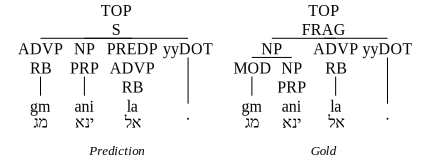

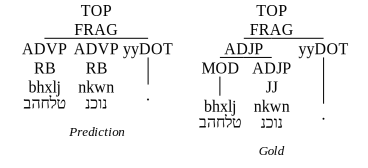

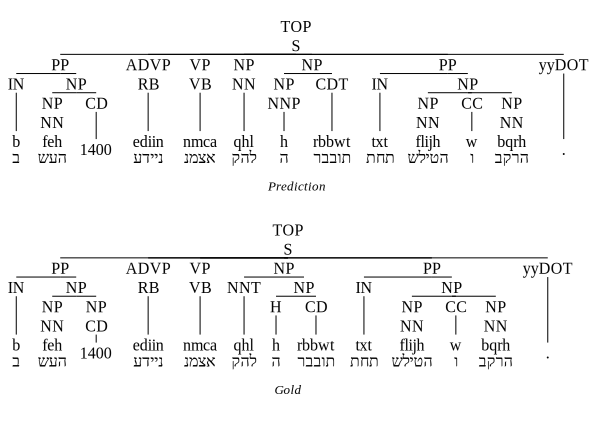

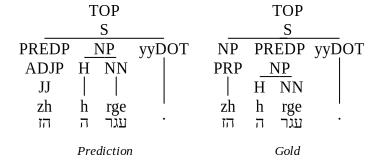

[None, None, None, None]

In [110]:
list(describe(int(l)) for l in evalb_df[(evalb_df['Tag Accracy']<80) & (evalb_df['Tag Accracy']>0) & (evalb_df['Contain unknowns']==False)]['ID'].values)

## Now, let's examin some mistakes:

As we can see below, in contrast to Solution 1.2, the improved solution can now parse __questions__ better.

This is now due to the fact that when parsing איזה, we now respect its possible parent and grand-parent. We saw in Q1.2 that WDT matches better to איזה, and now because NP matches fits well in the form of the sentence, both their probabilities help איזה get the right tag.

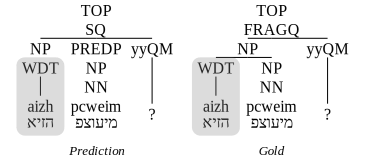

[('WDT@NP', ('AIZH',), 0.002523698141080881),
 ('DT@NP', ('AIZH',), 0.0009057189683429655)]

In [46]:
describe(5, [(0,0,0)], [(0,0,0)])
h3("איזה parents")
display(get_possible_terminal_tags('aizh'))

---
Many mistakes happen when parsing __proper nouns__, like __people names__. These are more unknown words that aren't treated 
properly.

## Now, let's gather some statistics

After we got a feeling from example mistakes, let's back it with data.

### Unknown words statistics

We can notice that sentences with unknown words are parsed less successfuly:

In [59]:
# For each row check if it contains unknown words

def does_contain_unknowns(line_num):
    leafs = to_leafs(predicted[int(line_num)-1])
    for leaf in leafs:
        if leaf not in known_words:
            return True
    return False

def is_question(line_num):
    leafs = to_leafs(predicted[int(line_num)-1])
    return leafs and leafs[-1] == 'yyQM'

evalb_df['Contain unknowns'] = evalb_df['ID'].apply(does_contain_unknowns)
evalb_df['Is question'] = evalb_df['ID'].apply(is_question)
evalb_df = evalb_df.assign(F1 = lambda x: 2 * x['Prec.'] * x['Recal'] / (x['Prec.'] + x['Recal']))

h3('')
h3("There's a negative correlation between existance of unknown words, and other performance metrics:")
evalb_df.corr()['Contain unknowns'].loc[['Tag Accracy', 'Prec.', 'Recal']]

Tag Accracy   -0.248366
Prec.         -0.085417
Recal         -0.192433
Name: Contain unknowns, dtype: float64

In [61]:
# Calc F1 for unknown words 

def df_f1(df):
    return round(df['F1'].mean(), 1)

h3("F1 scores are significally different for sentences with unknown words:")
print("F1 for all sentences", df_f1(evalb_df))
print("F1 for sentences with unknown words", df_f1(evalb_df[evalb_df['Contain unknowns']==True]))
print("F1 for sentences without unknown words", df_f1(evalb_df[evalb_df['Contain unknowns']==False]))

F1 for all sentences 79.8
F1 for sentences with unknown words 75.6
F1 for sentences without unknown words 86.6


We also notice that the vast majority of unknown words are tagged incorrectly, and that most sentences turned out to have unknown words in them.

In [212]:
import statistics

def unknown_mistake_ratio(line_num):
    leafs = to_leafs(predicted[int(line_num)-1])
    unknown = 0
    mistakes = 0

    evalb_tags = evalb[int(line_num)]
    for i, leaf in enumerate(leafs):
        if leaf not in known_words:
            unknown += 1
            t_predicted = evalb_tags['t-predicted'][i]
            t_gold = evalb_tags['t-gold'][i]
            assert t_predicted['tag']==leaf
            assert t_gold['tag']==leaf
            if t_predicted['parent']!=t_gold['parent']:
                mistakes += 1
    return mistakes / unknown if unknown else None

unknown_words_ratio = statistics.mean(map(unknown_mistake_ratio, list(evalb_df[evalb_df['Contain unknowns']==True]['ID'])))

h3("Ratio of sentences with unknown words")
ratio = len(evalb_df[evalb_df['Contain unknowns']==True]) / len(evalb_df)
print(round(ratio,2)*100, '%')

h3("Ratio of unknown words tagged incorrectly")
print(round(unknown_words_ratio,2)*100, '%')

66.0 %


71.0 %


## Missed non-terminal tags statistics

Let's try to investigate where non-terminal tags are parsed incorrectly

First, let's collect data about nodes in which level of the trees got wrong tags

In [81]:
# Add a height parameter to each NT tag, and find which layer in the tree had wrong tags

def set_heights(line_num, node=None):
    eval_tags = evalb[int(line_num)]
    nt_predicted = eval_tags['nt-predicted']
    if not node:
        node = nt_predicted[0]
    children = [c for c in nt_predicted[nt_predicted.index(node) + 1:] if node['start'] <= c['start'] < node['end']]
    if children:
        children_height = [set_heights(line_num, c) for c in children]
        node['height'] = max(children_height) + 1
    else:
        node['height'] = 2
    return node['height']
    
def incorrect_NT_stats(line_num):
    eval_tags = evalb[int(line_num)]
    set_heights(line_num)
    misses = defaultdict(int)
    misses['tree_height'] = eval_tags['nt-predicted'][0]['height']
    for p in eval_tags['nt-predicted']:
        # find the gold tag at the same position in the tree
        match_gold_nt = next((g for g in eval_tags['nt-gold'] if g['start']==p['start'] and g['end']==p['end']), None)
        if not match_gold_nt:
            misses[p['height']] += 1
    return misses

In [83]:
misses = dict((line_num, incorrect_NT_stats(line_num)) for line_num in evalb_df[evalb_df['Prec.']!=0]['ID'].values)

In [85]:
missed_layers_pct = []
for line_num, miss in misses.items():
    tree_height = miss['tree_height']
    missed_layers = len(miss.values()) - 1
    missed_percent = (missed_layers / (tree_height - 2))
    missed_layers_pct.append(missed_percent)
    
missed_df = pd.DataFrame(missed_layers_pct)

In [90]:
# missed_df contains the percent of levels in the tree that were tagged incorrectly
missed_df[:5]

,0
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.333333


Let's plot the distribution

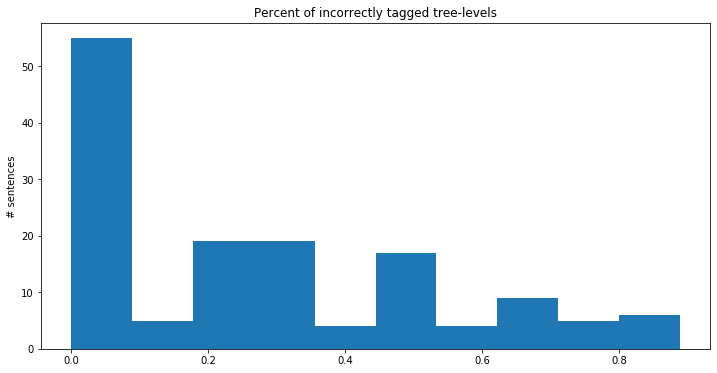

In [92]:
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

figsize(12, 6)
plt.hist(missed_df[0])
plt.title('Percent of incorrectly tagged tree-levels')
plt.ylabel('# sentences');

In [93]:
import statistics 
median = statistics.mean(v for v in missed_layers_pct if v)

h3(f"In cases were a tree was tagged incorrectly, on average {round(median*100)}% of its levels were wrong")

### Surprising results
This is surprising, failing to tag a non-terminal doesn't seem to always cause its parent to be tagged incorrectly.

This is a nice feature of CYK, where each node evenly respects the calculation of its two children, and may ignore a child mistake.